In [1]:
from dataclasses import dataclass
import math
import random
from typing import List, cast, Tuple
from matplotlib import patches
from matplotlib.collections import PatchCollection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inflect
import matplotlib
from matplotlib.colors import to_rgba
import random
from example import NotOkException, SlotGroup24, traffic_model

p = inflect.engine()


# Followings hard-coded in example.py
# FPR = 0.00216
# TPR = 0.99744


In [2]:

def doplot(gen_days, NN, h_magnitude = 50e3, n_magnitude_malicious = 10):
    days = 4
    width = 0.6
    for nn in range(NN):
        hours = np.arange(24)

        fig, axs = plt.subplots(3, days, figsize=(20,4), sharey="row")
        axs = cast(np.ndarray, axs)
        
        try:
            traffic_days,df = gen_days(h_magnitude, n_magnitude_malicious)
        except NotOkException as e:
            print(f'Try {nn}/{NN}: ', end='')
            print(e)
            continue

        th = traffic_days[0].fp().max()
        ymax = math.ceil(max([ day.p().max() for day in traffic_days]) / 100) * 100

        for idxday in range(days):

            healthycolor = np.full((24, 4), np.array(to_rgba('grey', 0), dtype=np.float64), dtype=np.float64)
            maliciouscolor = np.full((24, 4), np.array(to_rgba('black', 0), dtype=np.float64), dtype=np.float64)
            
            negativemask = np.full((24, 4), np.array([0,0,0,0.2]), dtype=np.float64)
            positivemask = np.full((24, 4), np.array([0,0,0,0.6]), dtype=np.float64)

            background_color = to_rgba('gray', 0.1)

            day = traffic_days[idxday]
            fp = day.fp()
            tp = day.tp()
            tp[tp<5] = 0

            axs[0, idxday].bar(hours, fp, bottom=0, width=width, color=healthycolor + positivemask, label="FPs")
            axs[0, idxday].set_ylim(0, ymax)

            axs[1, idxday].bar(hours, tp, bottom=0,  width=width, color=maliciouscolor + positivemask, label="TPs")
            axs[1, idxday].set_ylim(0, ymax)

            axs[2, idxday].bar(hours, fp, bottom=0,       width=width, color=healthycolor + positivemask, label="FPs")
            axs[2, idxday].bar(hours, tp, bottom=fp,     width=width, color=maliciouscolor + positivemask, label="TPs")

            ###
            tmp = day.tpa(th)
            if tmp.sum() > 0:
                axs[2, idxday].bar(hours[tmp], day.p()[tmp], lw=1, width=width, edgecolor='royalblue', color=to_rgba("#FFFFFF00"), label='Detection')

            tmp = day.fna(th)
            if tmp.sum() > 0:
                axs[2, idxday].bar(hours[tmp], day.p()[tmp], lw=1, width=width, edgecolor='red', color=to_rgba("#FFFFFF00"), label='Non-detection')
                
            tmp = day.fpa(th)
            if day.fpa(th).sum() > 0:
                axs[2, idxday].bar(hours[day.fpa(th)], day.p()[day.fpa(th)], lw=1, width=width, edgecolor='orange', color=to_rgba("#FFFFFF00"), label="Misdetection")
            ###

            axs[2, idxday].set_ylim(0, ymax)

            for i in range(3):
                axs[i, idxday].set_xticks([])
                axs[i, idxday].set_facecolor(background_color)
                pass

            hours_labels_pos = [0, 7, 15, 23]
            hours_labels = [
                '$1^{{st}}$ hr',
                '$8^{th}$',
                '$16^{th}$',
                '$24^{th}$'
            ]
            axs[-1, idxday].set_xticks(hours_labels_pos, hours_labels)

            pad = 16
            axs[0, 0].set_ylabel("False Positives (FPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[1, 0].set_ylabel("True Positives (TPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[2, 0].set_ylabel("TPs + FPs", rotation='vertical', labelpad=pad, size='medium')
            
            axs[-1, idxday].set_xlabel([
                "\"setting the threshold\" day",
                "\"false positive alarms\" day",
                "\"missed detection\" day",  
                "\"infection detected\" day"
            ][idxday], size='medium')
        
            if idxday == 0:
                axs[-1, idxday].axhline(th, linewidth=0.8, color='black', label="Threshold setting", linestyle="--")
            else:
                axs[-1, idxday].axhline(th, linewidth=0.8, color='black', label="Threshold", linestyle="-")
            pass

        for i in range(axs.shape[0]):
            for ax in axs[i,:]:
                ax.set_ylim(axs[0,0].get_ylim())

        fig.set_size_inches(18,6)
        fig.subplots_adjust(left=0.08, top=0.95, right=0.98, bottom=0.05,
        hspace=0.1, wspace=0.2)

        ls_pos = [ 'Threshold setting', 'Threshold', 'FPs', 'TPs', 'Misdetection', 'Detection', 'Non-detection' ]
        newhs, newls = list(range(7)), list(range(7))
        for ax in fig.axes:
            hs, ls = ax.get_legend_handles_labels()
            for idxl, l in enumerate(ls):
                if l not in newls:
                    newhs[ls_pos.index(l)] = hs[idxl]
                    newls[ls_pos.index(l)] = l
                pass
        fig.legend(newhs, newls, loc='outside upper center', ncols=4)
        fig.savefig(f"plot_{nn}.pdf", bbox_inches="tight")

        nn += 1

        plt.show()
        plt.close()

        pass
    pass

NameError: name 'doday' is not defined

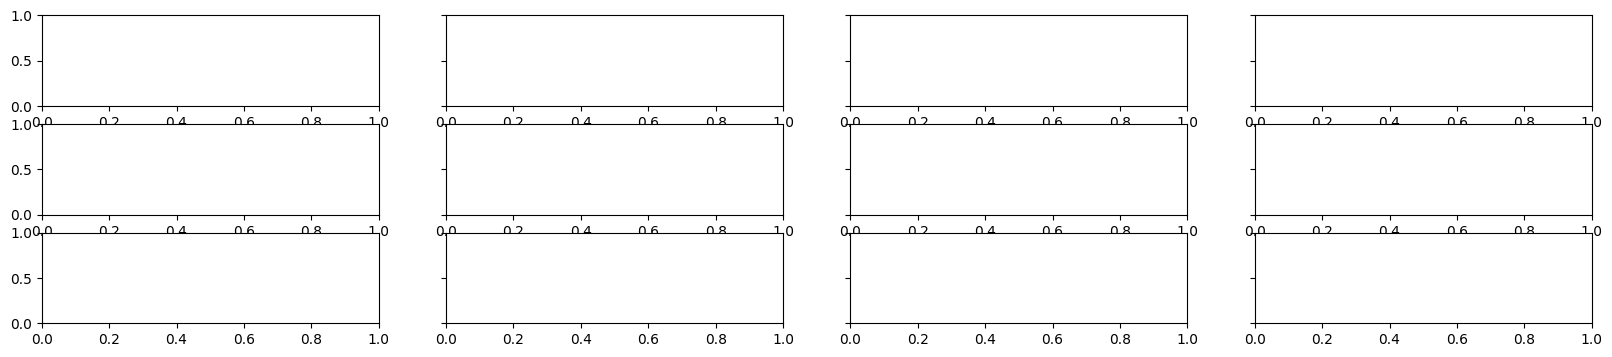

In [3]:

def gen_days(h_magnitude = 50e3, n_magnitude_malicious = 10):
        
    day1 = SlotGroup24().healthy(h_magnitude)
    th = day1.fp().max()

    def doday3():
        day3 = SlotGroup24().both(h_magnitude, 10, 0)
        day3._malicious[1, [ random.randint(0,23) for _ in range(12) ]] = 0
        for _ in range(8):
            day3._malicious[1, random.randint(0,23)] *= 0.05
        return day3
    
    N = 1000
    doday2 = lambda: SlotGroup24().healthy(1.05 * h_magnitude)
    doday4 = lambda: day3.copy().healthy(h_magnitude * 0.95)

    day2, df2 = doday(N, 'Falses', doday2, th, fpa=(1, 12, +80))
    day3, df3 = doday(N, 'Missed', doday3, th, fna=(1, 8, -80), tpa=(0, 0, 0), fpa=(0,0,0))
    day4, df4 = doday(N, 'Detected', doday4, th, fna=(0, 12, -30), tpa=(4, 12, +15))

    return [ day1, day2, day3, day4 ], pd.concat([df2,df3,df4])

doplot(gen_days, 3, h_magnitude=50000, n_magnitude_malicious=50000)

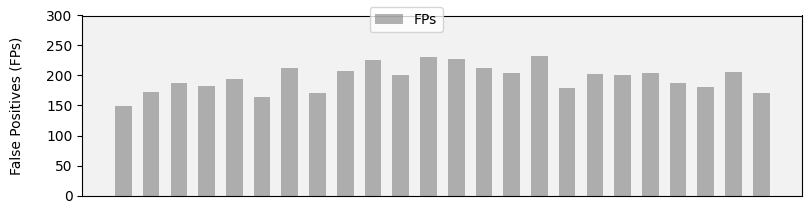

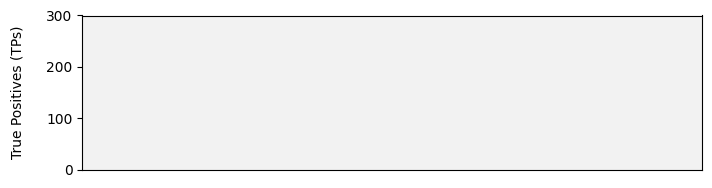

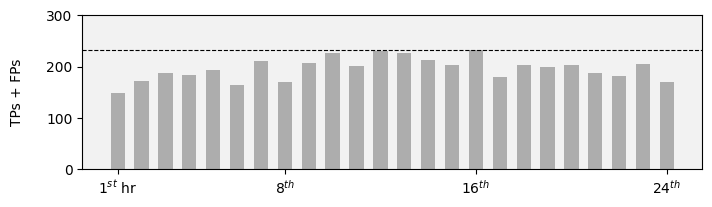

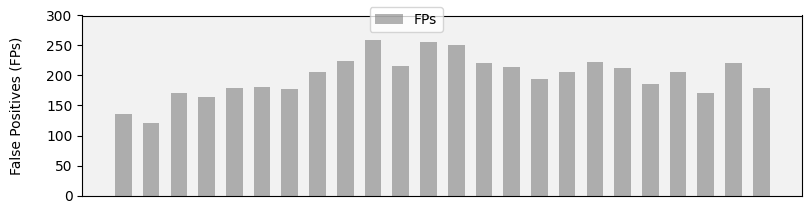

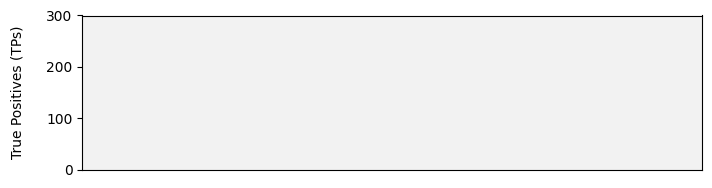

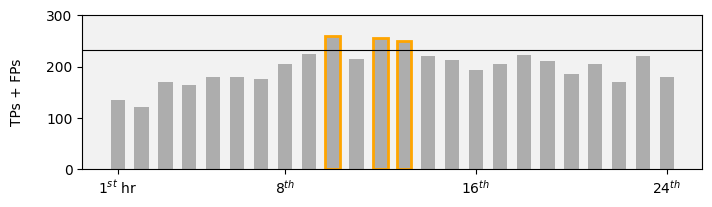

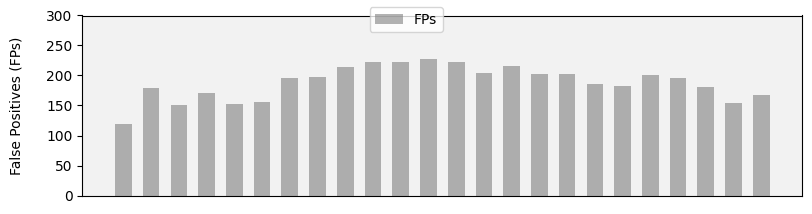

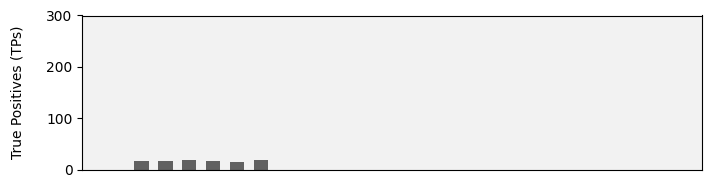

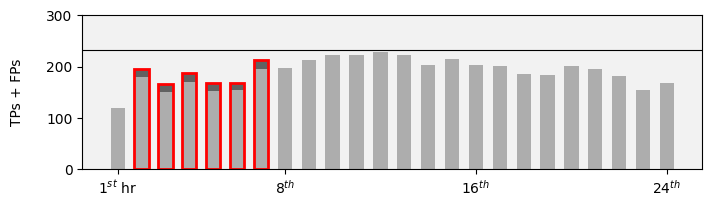

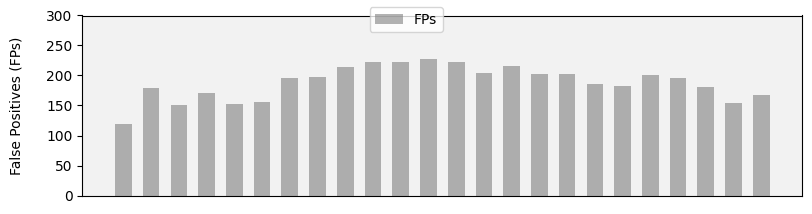

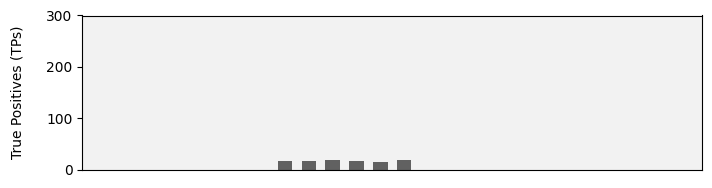

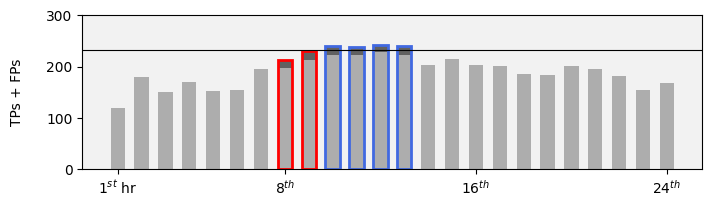

Falses not done
Falses not done


In [105]:
from typing import Dict

def doday(day: SlotGroup24, name, th, alerts: Dict[str, Tuple[int, int, int]]):
    def between(x, l, h): return x >= l and x <= h
    ok = True
    for an in alerts:
        okalerts = day.alert(an[0:2], th + alerts[an][2])
        if not between(okalerts.sum(), alerts[an][0], alerts[an][1]):
            # print(f'Err {name} okalerts', okalerts.sum(), th + alerts[an][2], alerts[an][0], alerts[an][1])
            ok = False
            break
        notokalerts = day.alert(an[0:2], th).sum() - okalerts.sum()
        if notokalerts.sum() > 2:
            # print('Err notokalerts', notokalerts.sum())
            ok = False
            break
        pass

    # if not ok:
    #     print(f"""Day '{name}' not done""")
        # raise NotOkException(f"""Day '{name}' not done""")

    return ok

def gen_days(h_magnitude = 50e3, n_magnitude_malicious = 10, hm1=1.15, hm2=0.9):
    for _ in range(1000):
        day1 = SlotGroup24().healthy(h_magnitude)
        unico_ordinato = np.unique(day1._healthy)[::-1]
        if unico_ordinato[0] - unico_ordinato[1] > 10:
            continue
        pass
    th = day1.fp().max()

### DAY2 ################################################################
    ok2 = False
    for _ in range(1000):
        day2 = SlotGroup24().healthy(h_magnitude)
        tmp = None
        for _  in range(1000):
            tmp = list(([ random.randint(0,24) for __ in range(8) ]))
            if len(tmp) == 8: break
            pass
        if tmp is None:
            raise Exception(f'tmp is none {tmp}')
        for i in range(24):
            day2._healthy[1, i] *= 1.4 if i in tmp else 1.2
        if doday(day2, 'Falses', th, dict(fpa=(2, 2, +20))):
            ok2 = True
            break
    if not ok2:
        print('Falses not done')
### DAY3 ###############################################################
    ok34 = False
    tmp = 1
    for _ in range(10000):
        day3 = SlotGroup24().both(h_magnitude, 5, 0)
        day3._healthy[1, tmp:tmp+6] = (day3._healthy[1, tmp:tmp+6].astype(np.float64) * 0.95).astype(int)

        day3._malicious[1, tmp:tmp+6] = (day3._malicious[1, tmp:tmp+6].astype(np.float64) * 2).astype(int)
        day3._malicious[1, 0:tmp] *= 0
        day3._malicious[1, tmp+6:24] *= 0
        if doday(day3, 'Missed', th, dict(fna=(1, 16, -10), tpa=(0, 0, 0), fpa=(0,0,0))):
### DAY4 ###############################################################
            day4 = day3.copy()#.healthy(h_magnitude * 0.95)
            day4._healthy[1, tmp+6:tmp+12] = (day3._healthy[1, tmp+6:tmp+12].astype(np.float64) * 1.15).astype(int)
            day4._malicious = np.roll(day4._malicious, 6)
            if doday(day4, 'Detected', th, dict(fna=(0, 12, -5), tpa=(3, 12, +5), fpa=(0,0,0))):
                ok34 = True
                break
    if not ok34:
        print('Missed/Detected not done')
########################################################################
    
    return [ day1, day2, day3, day4 ], all([ok2,ok34])

doplot_single(gen_days, NN=3)


In [104]:

def doplot_single(gen_days, NN, tries=3):
    days = 4
    width = 0.6
    nn = 0
    hours = np.arange(24)
    for _try in range(tries):
        if nn >= NN:
            break

        traffic_days, ok = gen_days()

        if not ok:
            continue

        nn += 1

        th = traffic_days[0].fp().max()
        ymax = math.ceil(max([ day.p().max() for day in traffic_days]) / 100) * 100

        for idxday in range(days):
            fig1, ax1 = plt.subplots(1, 1, figsize=(8,2))
            fig2, ax2 = plt.subplots(1, 1, figsize=(8,2))
            fig3, ax3 = plt.subplots(1, 1, figsize=(8,2))
            figs = [fig1,fig2,fig3]
            axs = [ax1,ax2,ax3]

            healthycolor = np.full((24, 4), np.array(to_rgba('grey', 0), dtype=np.float64), dtype=np.float64)
            maliciouscolor = np.full((24, 4), np.array(to_rgba('black', 0), dtype=np.float64), dtype=np.float64)
            
            negativemask = np.full((24, 4), np.array([0,0,0,0.2]), dtype=np.float64)
            positivemask = np.full((24, 4), np.array([0,0,0,0.6]), dtype=np.float64)

            background_color = to_rgba('gray', 0.1)

            day = traffic_days[idxday]
            fp = day.fp()
            tp = day.tp()
            tp[tp<5] = 0

            axs[0].bar(hours, fp, bottom=0, width=width, color=healthycolor + positivemask, label="FPs")
            axs[0].set_ylim(0, ymax)

            axs[1].bar(hours, tp, bottom=0,  width=width, color=maliciouscolor + positivemask, label="TPs")
            axs[1].set_ylim(0, ymax)

            axs[2].bar(hours, fp, bottom=0,       width=width, color=healthycolor + positivemask, label="FPs")
            axs[2].bar(hours, tp, bottom=fp,     width=width, color=maliciouscolor + positivemask, label="TPs")

            ###
            tmp = day.tpa(th)
            if tmp.sum() > 0:
                axs[2].bar(hours[tmp], day.p()[tmp], lw=2, width=width, edgecolor='royalblue', color=to_rgba("#FFFFFF00"), label='Detection')

            tmp = day.fna(th)
            if tmp.sum() > 0:
                axs[2].bar(hours[tmp], day.p()[tmp], lw=2, width=width, edgecolor='red', color=to_rgba("#FFFFFF00"), label='Non-detection')
                
            tmp = day.fpa(th)
            if day.fpa(th).sum() > 0:
                axs[2].bar(hours[day.fpa(th)], day.p()[day.fpa(th)], lw=2, width=width, edgecolor='orange', color=to_rgba("#FFFFFF00"), label="Misdetection")
            ###

            axs[2].set_ylim(0, ymax)

            for i in range(3):
                axs[i].set_xticks([])
                axs[i].set_facecolor(background_color)
                pass

            hours_labels_pos = [0, 7, 15, 23]
            hours_labels = [
                '$1^{{st}}$ hr',
                '$8^{th}$',
                '$16^{th}$',
                '$24^{th}$'
            ]
            axs[-1].set_xticks(hours_labels_pos, hours_labels)

            pad = 16
            axs[0].set_ylabel("False Positives (FPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[1].set_ylabel("True Positives (TPs)", rotation='vertical', labelpad=pad, size='medium')
            axs[2].set_ylabel("TPs + FPs", rotation='vertical', labelpad=pad, size='medium')
            
            # axs[-1].set_xlabel([
            #     "\"setting the threshold\" day",
            #     "\"false positive alarms\" day",
            #     "\"missed detection\" day",  
            #     "\"infection detected\" day"
            # ][idxday], size='medium')
            axs[-1].set_xlabel('')
        
            if idxday == 0:
                axs[-1].axhline(th, linewidth=0.8, color='black', label="Threshold setting", linestyle="--")
            else:
                axs[-1].axhline(th, linewidth=0.8, color='black', label="Threshold", linestyle="-")
            pass

            for ax in axs[:]:
                ax.set_ylim(axs[0].get_ylim())

        # fig.set_size_inches(18,6)
            for row, fig in enumerate(figs):
                fig.subplots_adjust(left=0.08, top=0.95, right=0.98, bottom=0.05,
                hspace=0.1, wspace=0.2)

                ls_pos = [ 'Threshold setting', 'Threshold', 'FPs', 'TPs', 'Misdetection', 'Detection', 'Non-detection' ]
                newhs, newls = list(), list()
                for ax in fig.axes:
                    hs, ls = ax.get_legend_handles_labels()
                    for idxl, l in enumerate(ls):
                        if l not in newls:
                            newhs.append(hs[idxl])
                            newls.append(l)
                        pass
                fig.legend(newhs, newls, loc='outside upper center', ncols=6)
                # fig.legend(loc='outside right', ncols=1)
                fig.savefig(f"plot_{nn}/day{idxday}_row{row}.pdf", bbox_inches="tight")

                plt.show()
                plt.close()
            pass
        pass
    pass

Try 0/3: Day 'Detected' not done:
tna: True	12	(0, inf, 0)
fpa: True	0	(0, inf, 0)
tpa: False	0	(2, 12, 5)
fna: True	12	(0, 12, -5)
Try 1/3: Day 'Detected' not done:
tna: True	11	(0, inf, 0)
fpa: True	0	(0, inf, 0)
tpa: False	0	(2, 12, 5)
fna: False	13	(0, 12, -5)


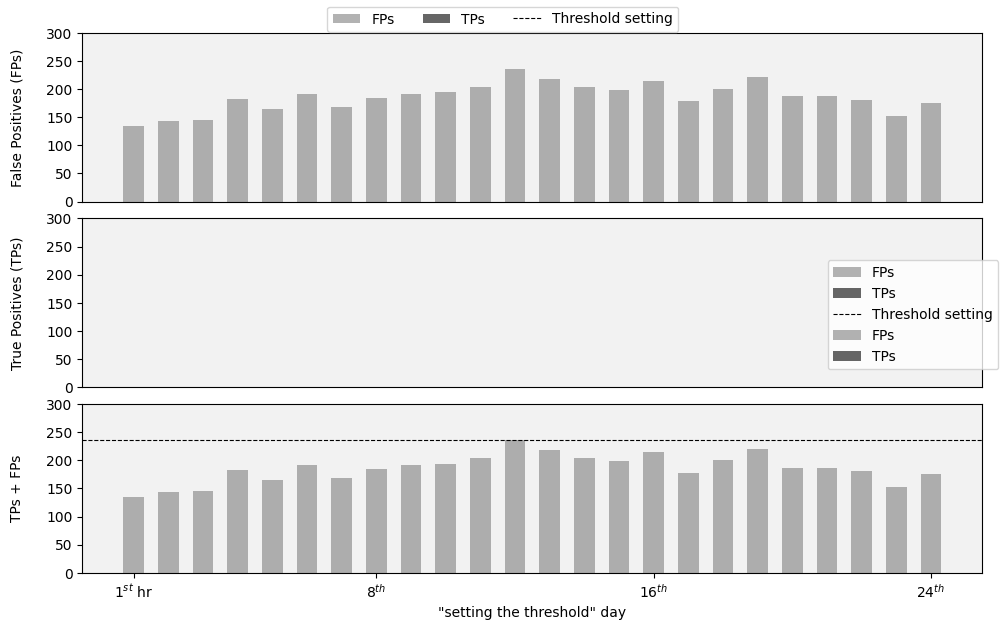

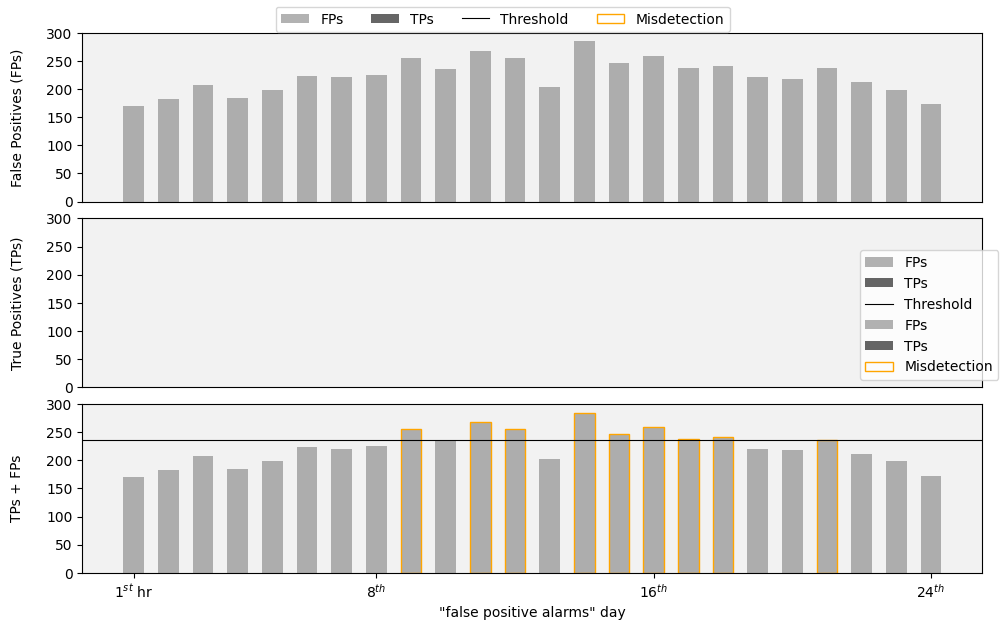

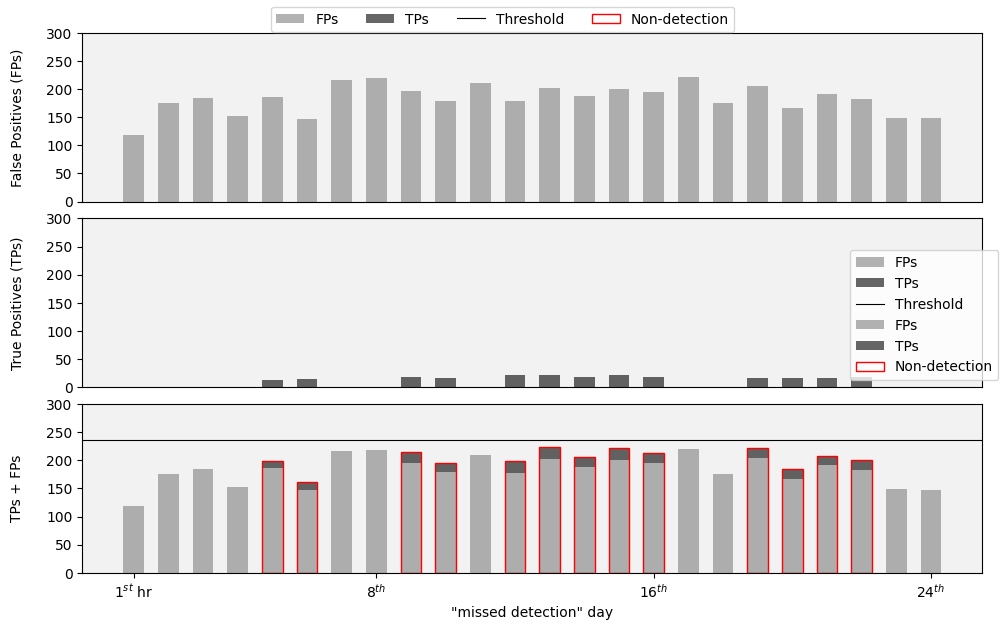

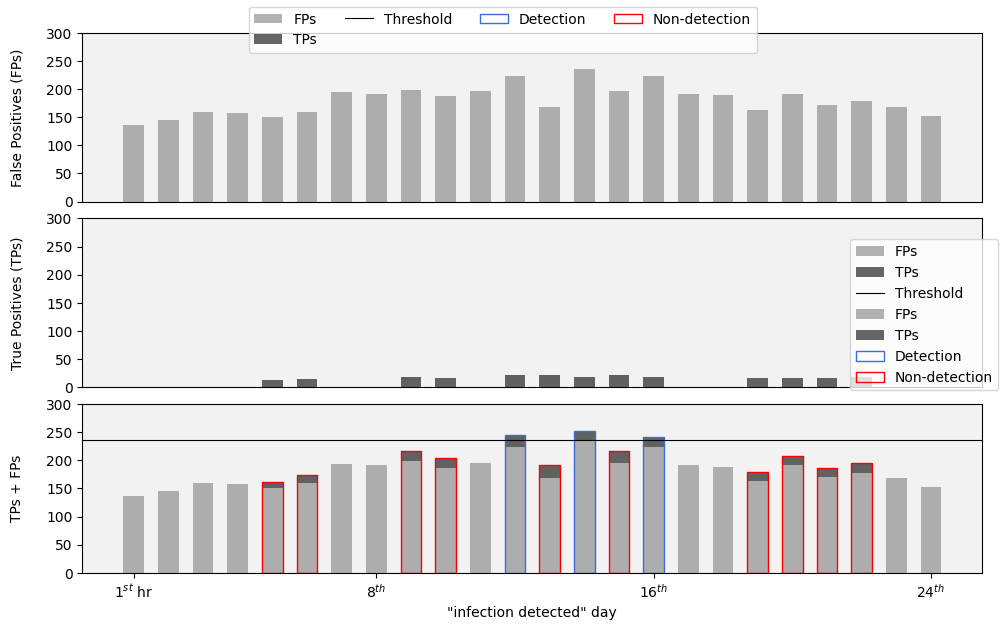

In [6]:

doplot_single(gen_days, 3, h_magnitude=50000, n_magnitude_malicious=50000)